In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors  
from rdkit.Chem import Lipinski
from rdkit import DataStructs
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

#import pubchempy as pcp
#from IPython.display import Imag

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#from sklearn.model_selection import train_test_split
#from sklearn import metrics
#from sklearn.ensemble import RandomForestRegressor

#import torch
from scipy import stats
import os

# Function

In [2]:
## Remove data column with std=0
def clean_std(df):
    print('Before clean', df.shape )
    #X_features.loc[ :, X_features.std() > X_features.mean() ]
    df_new = df.loc[ :, df.std()>0 ]
    print('After clean', df_new.shape )
    return df_new

# Remove high correlated data, step by step
def remove_high_corr_gradually(df, cutoff=0.9, highlight=None):
    corr_matx = df.corr()
    #sns.heatmap(corr_matx.abs())
    # The upper triangle of absolute values
    upper_tri = corr_matx.abs().where(np.triu(np.ones(corr_matx.shape),k=1).astype(bool))
    upper_tri = upper_tri>cutoff
    
    for n in range(len(upper_tri)):
        if upper_tri.sum().sum()>0:
            ## Find which one has the most overlap 
            occur = upper_tri.sum(axis=0).add( upper_tri.sum(axis=1) ).sort_values(ascending=False)
            bad_fp = list( occur.index )[0]
            #print( bad_fp, occur[bad_fp])
            upper_tri.drop( bad_fp, axis=1, inplace=True)
            upper_tri.drop( bad_fp, axis=0, inplace=True)
        else:
            break
    
    print("Num of keep: ",len(upper_tri.columns))
    print("Num of drop: ",len(df.columns)-len(upper_tri.columns))
    print("---------")
    
    if highlight is not None:
        highlight = corr_matx[ highlight ]
        
    return  df[ upper_tri.columns ], highlight

## Standardization of a pd dataframe
def get_std(data_x):   
    scaler = StandardScaler()
    scaler.fit(data_x)
    X_scale = scaler.transform(data_x)
    data_new = pd.DataFrame(X_scale, columns=data_x.columns, index=data_x.index)
    return data_new, scaler  ## Save the new data, and its scaler

def perform_pca_n(df, n_pca, if_plot=None, top_features=0, save_to_file=None):
    X_scale,scaler = get_std(df)

    pca = PCA(n_components=n_pca)
    principal = pca.fit_transform(X_scale)
    
    num_pc = pca.n_components_
    name_pc = [ f'pc{n+1}' for n in range(num_pc) ]
    df_pca = pd.DataFrame(data=principal, columns=name_pc, index=df.index)

    ## See what PCA can tell
    explained_var = pca.explained_variance_ratio_
    print('Total Var ', np.sum(explained_var) ,' from ',len(explained_var) )
    print('Exp Var: ', explained_var)
    
    explained_var = explained_var*100

    fig, axs = plt.subplots(1,1, figsize=(3.5,2.5),tight_layout=True)
    x = [i+1 for i in range(len(explained_var))]
    axs.bar(x, explained_var, color='magenta', label='Single')
    axt = axs.twinx()
    total_var = [ np.sum(explained_var[:i]) for i in range(len(explained_var))]
    axt.plot(x, total_var, color='navy', label='Total')
    axs.set_xlim([0.01, len(x)+0.99])
    axs.set_xlabel('Principal components',fontsize=10) ## input X name
    axs.set_ylabel('Single \nexplained variance (%)',fontsize=10) ## input Y name
    axt.set_ylabel('Total \nexplained variance (%)',fontsize=10) ## input Y name
    axs.tick_params(direction='in',labelsize=8)
    axt.tick_params(direction='in',labelsize=8)

    handles1, labels1 = axs.get_legend_handles_labels()
    handles2, labels2 = axt.get_legend_handles_labels()
    fig.legend(handles1+handles2, labels1+labels2, ncol=1, loc='center right', bbox_to_anchor=(0.75, 0.5),
               fontsize=8, frameon=False, handlelength=1, handletextpad=0.2, columnspacing=1)

    if save_to_file is not None:
        plt.savefig(save_to_file, dpi=1200)
    plt.show()

    component = pca.components_
    pca_coeff = pd.DataFrame(data=np.transpose(component), columns=name_pc)
    pca_coeff.index = X_scale.columns
    
    if if_plot is not None:
        contribution = (pca_coeff*explained_var)**2
        contribution['Total'] = np.sqrt( contribution.sum(axis=1) )
        contribution = contribution.sort_values('Total',ascending=True)
        if top_features>=1:
            fig, axs = plt.subplots(1,1, figsize=(3,0.2*top_features),tight_layout=True)
            contribution.tail(top_features).plot(kind='barh', stacked=True, y=name_pc, ax=axs) #, color=['red','skyblue'])
        elif top_features>0:
            top_features = contribution['Total'].tail(1).values[0]*top_features
            contribution = contribution[ contribution['Total'] >= top_features ]
            fig, axs = plt.subplots(1,1, figsize=(3,0.2*len(contribution)),tight_layout=True)
            contribution.plot(kind='barh', stacked=True, y=name_pc, ax=axs) #, color=['red','skyblue'])
        else:
            fig, axs = plt.subplots(1,1, figsize=(3,3),tight_layout=True)  #figsize=(3.5,0.2*len(explained_var)
            contribution.plot(kind='barh', stacked=True, y=name_pc, ax=axs) #, color=['red','skyblue'])
        axs.set_yticks( [] )
        axs.set_xlabel('Variable weighting in PC', fontsize=10)
        axs.set_ylabel('All features', fontsize=10)
        axs.tick_params(direction='in',labelsize=8)
        axt.tick_params(direction='in',labelsize=8)
        #axs.get_legend().remove()
        n_pc_show = 5
        handles, labels = axs.get_legend_handles_labels()
        handles, labels = handles[:n_pc_show+1], [b.strip() for b in labels[:n_pc_show+1]]
        labels[-1] = 'Other pc'
        axs.legend( handles,labels, ncol=1, loc='lower right', #bbox_to_anchor=(-0.1, 1.0),
                   fontsize=8, frameon=False, handlelength=1, handletextpad=0.2, columnspacing=1 )
    
        plt.savefig(if_plot, dpi=1200)
        plt.show()
    return df_pca, pca_coeff, explained_var

def plot_pca_2d(df_pca, pca_coef, color, xname='pc1', yname='pc2' , wname=None, cbar_label='LUMO (eV)',
                feature_arrow=False, num_feature=10, xrange=None, yrange=None, color_map='jet',
                size=None, explained_var=None, save_to_file=None, data_alpha=0.5):
    """
    df_pca: the pca dataframe
    df_coef: the pca coefficient
    xname,yname: the name for pc, e.g. pc2, pc3. 
    color: the list for color
    """
    color_map = color_map
    fig, axs = plt.subplots(1,1, figsize=(3.5,2.5),tight_layout=True)
    if wname==None:
        if size is not None:
            im = axs.scatter( df_pca[xname], df_pca[yname], c=color, cmap=color_map,alpha=data_alpha,edgecolors='none', s=size)
        else:
            im = axs.scatter( df_pca[xname], df_pca[yname], c=color, cmap=color_map,alpha=data_alpha,edgecolors='none')
    else:
        size =(df_pca[wname] - np.amin(df_pca[wname]))*10 
        im = axs.scatter( df_pca[xname], df_pca[yname], c=color, cmap=color_map,alpha=data_alpha,edgecolors='none', s=size)
    
    if xrange is not None:
        axs.set_xlim(xrange)
    if yrange is not None:
        axs.set_ylim(yrange)
    
    axs.set_xlabel(xname,fontsize=10) ## input X name
    axs.set_ylabel(yname,fontsize=10) ## input Y name
    axs.tick_params(direction='in',labelsize=8)
        
    ## The feature contribution
    if feature_arrow:
        if explained_var is not None:
            if 'length' not in pca_coef.columns:
                pca_coef['length'] = np.sqrt(np.sum( (pca_coef*explained_var)**2, axis=1 ))
        else:
            pca_coef['length'] = np.sqrt( pca_coef[xname]**2 + pca_coef[yname]**2 )
        pca_coef = pca_coef.sort_values('length',ascending=False)
        pca_coef_head = pca_coef.head(num_feature)
        #display('In plot',pca_coef)
        factor = 20
        for i,(m,c1,c2) in enumerate(zip(pca_coef_head.index, pca_coef_head[xname], pca_coef_head[yname])):
            axs.arrow(0,0, c1*factor, c2*factor, head_width=0.3, 
                      facecolor='silver', edgecolor='k', alpha=0.5)
            print( str(i),m )
            axs.text( c1*factor*1.2, c2*factor*1.2, str(i), ha='center', va='center', fontsize=6 )
    #comp = comp*var*100  # scale comp by its variance explaination power
    #axs.plot([0,c1*10],[0,c2*10], label=m, lw=3, linestyle='-',marker='o',markersize=7)
    
    fig.colorbar(im, shrink=0.8, label=cbar_label, pad=0.02)
    
    if save_to_file is not None:
        plt.savefig(save_to_file, dpi=1200)     

    #im.set_clim( df.min().min(), df.max().max() )
    plt.show()

import matplotlib.colors as mcolors
def feature_weight( pca_coef, explained_var, num_variable=10, if_var_considered=False, header=None, save_to_file=None, fig_size=None):
    pc_names = list(pca_coef.drop('length',axis=1).columns)
    #print(pc_names)
    
    if if_var_considered:
        weight = (pca_coef[pc_names]*explained_var)**2
        weight['length'] = weight.sum(axis=1)
    weight = weight.sort_values('length',ascending=False)
    weight = weight.head(num_variable)
    if header is not None:
        weight.index = [i.replace(header,'')+f'({n})' for n,i in enumerate(weight.index)]
    clean_index = []
    for i in weight.index:
        i = i.replace('Cat ','Catalyst ')
        i = i.replace('Catalyst2','Catalyst')
        i = i.replace('Solvent2','Solvent')
        i = i.replace('Ligand2','Ligand')
        i = i[0].upper()+i[1:]
        clean_index.append(i)
    weight.index = [i.replace('PubchemFP','Pubchem') for i in clean_index ]
    #display(weight)
    n_pc_show = 5
    colors = ['tab:cyan' for p in pc_names]
    colors = list(mcolors.TABLEAU_COLORS.keys())[:n_pc_show] + colors[n_pc_show:]
    
    if fig_size is None: fig_size = (3.5,0.2*num_variable)
    fig, axs = plt.subplots(1,1, figsize=fig_size, tight_layout=True)
    p1 = weight.plot(kind='barh', y=pc_names, ax=axs, stacked=True, color=colors)#, colormap='tab10')
    axs.set_xlabel('Weighting',fontsize=10) ## input X name
    #axs.set_ylabel('Variables',fontsize=10) ## input Y name
    axs.tick_params(direction='in',labelsize='8')
    axs.invert_yaxis()
    #axs.set_xlim( right=p1.get_xlim()[1]*1.1 )
    axs.get_legend().remove()
    #handles, labels = axs.get_legend_handles_labels()
    #handles, labels = handles[:n_pc_show+1], [b.strip() for b in labels[:n_pc_show+1]]
    #labels[-1] = 'Other pc'
    #axs.legend( handles,labels, ncol=int(len(labels)/2), loc='lower left', bbox_to_anchor=(-0.1, 1.0),
    #           fontsize=8, frameon=False, handlelength=1, handletextpad=0.2, columnspacing=1 )
    #plt.tight_layout()
    if save_to_file is not None:
        plt.savefig(save_to_file, dpi=1200)    
    plt.show()
    return list(weight.index)

from sklearn.manifold import TSNE
def perform_tsne_n(df, n_tsne=2, **kwargs):
    X_scale,scaler = get_std(df)
    tsne = TSNE(n_components=n_tsne, **kwargs)
    principal = tsne.fit_transform( X_scale ) 
    name_comp = [ f'tsne_{n+1}' for n in range(n_tsne) ]
    df_tsne = pd.DataFrame(data=principal, columns=name_comp, index=df.index)
    return df_tsne 

def plot_tsne_2d(df_tsne, color, xname='tsne_1', yname='tsne_2', 
                 color_map='cool', clim=None, cbar_label='',                
                 save_to_file=None):
    fig, axs = plt.subplots(1,1, figsize=(3.5,2.5),tight_layout=True)
    size = 20
    im = axs.scatter( df_tsne[xname], df_tsne[yname], c=color, cmap=color_map, alpha=0.8,edgecolors='none', s=size)
    #axs.set_xlim((ax_min,ax_max))
    #axs.set_ylim((ax_min,ax_max))
    axs.set_xlabel(xname,fontsize=10) ## input X name
    axs.set_ylabel(yname,fontsize=10) ## input Y name
    axs.tick_params(direction='in',labelsize=8)
    
    fig.colorbar(im, shrink=0.8, label=cbar_label, pad=0.02)
    if clim is not None:
        im.set_clim( color.quantile(clim[0]),color.quantile(clim[1]) )
    if save_to_file is not None:
        plt.savefig(save_to_file, dpi=1200)   
    plt.show()

from PIL import Image,ImageDraw,ImageFont
def interpret_pubchemFP_name(name, pubchem_list, num_rows=None):
    output = []
    for m in name:
        m=m.split('(')
        pubchem_bit = m[0].split('Pubchem')
        compound = pubchem_bit[0].replace( '_', ' ').strip()
        compound = compound[0].upper()+compound[1:]
        if len(pubchem_bit)==1:
            pubchem_bit = ''
        elif len(pubchem_bit)==2:
            compound = compound +'\nPubChem bit #'+ pubchem_bit[1]+'\n'
            pubchem_bit = pubchem_list[ int(pubchem_bit[1]) ]
            if len(pubchem_bit)>20:
                pubchem_bit = pubchem_bit[:20]
            compound += pubchem_bit
        try:
            mol = Chem.MolFromSmarts(pubchem_bit)
        except:
            mol = None
        output.append( [mol, compound] )
    font1=ImageFont.truetype("Times New Roman.ttf", size=24)
    imgs = []
    for m in output:
        img = Image.new('RGB', (200,100), color = (255,255,255))
        img1 = ImageDraw.Draw(img)
        img1.text((10,10), m[1], fill=(51,153,102), align='center', font=font1)
        if m[0] is None:
            img2 = Image.new('RGB', (200,100), color = (255,255,255))
        else:
            img2 = Draw.MolToImage( m[0], size=(200,100), )
        combine = Image.new('RGB', (400,100), color = (255,255,255))
        combine.paste(img, (0, 0))
        combine.paste(img2, (200, 0))
        imgs.append( combine )
    if num_rows is None:
        num_rows = 5
    if len(imgs)/num_rows == int(len(imgs)/num_rows):
        num_cols = int(len(imgs)/num_rows)
    else:
        num_cols = int(len(imgs)/num_rows)+1
    img_size = (400*num_cols, 100*num_rows)
    New_img = Image.new('RGB', img_size, color=(255,255,255) )
    for i in range(len(imgs)):
        col = int(i/num_rows)*400
        row = i%num_rows*100
        New_img.paste( imgs[i], (col, row) )
    return New_img


In [3]:
Translate_pubchem_fingerprint = pd.read_csv( 'list_pubchem_fingerprint.csv').fillna('')
Translate_pubchem_fingerprint = { p: f'{s}{m}' for p,s,m in zip(Translate_pubchem_fingerprint['Bit_Position'],Translate_pubchem_fingerprint['Symbol'],Translate_pubchem_fingerprint['Bit_Substructure']) }
#print( Translate_pubchem_fingerprint )

# Pick C-C

In [4]:
df_cc = pd.read_csv("df_pubchem_CC.csv", index_col=0)
df_pubchem = clean_std(df_cc)
X_pubchem, _= remove_high_corr_gradually(df_pubchem, cutoff=0.8,)# highlight=['LUMO'])
Y_label = 'Yield%'
Y = X_pubchem[[Y_label,'source']]
X = X_pubchem.drop([Y_label,'source'],axis=1)

Before clean (193, 5295)
After clean (193, 1040)
Num of keep:  150
Num of drop:  890
---------


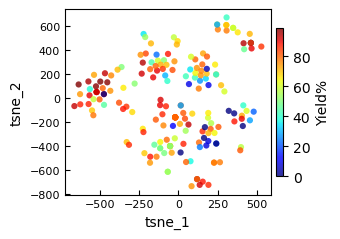

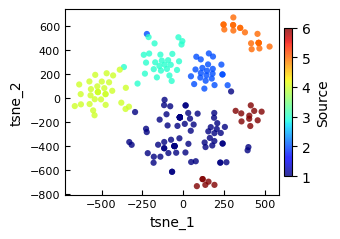

In [5]:
df2_tsne =  perform_tsne_n( X, n_tsne=2,  
                               verbose=0, 
                               random_state=100,
                               init='pca',
                               learning_rate='auto', 
                               perplexity=20, 
                               n_iter=3000 
                              )
plot_tsne_2d(df2_tsne, Y[Y_label],  xname='tsne_1', yname='tsne_2', cbar_label='Yield%', color_map='jet', save_to_file='Figure_TSNE_CC_pubc_yield.png') 
plot_tsne_2d(df2_tsne, Y['source'], xname='tsne_1', yname='tsne_2', cbar_label='Source', color_map='jet', save_to_file='Figure_TSNE_CC_pubc_source.png') 

Total Var  0.806005849013601  from  41
Exp Var:  [0.08791622 0.06841654 0.06225389 0.05271143 0.03713603 0.03466108
 0.03149183 0.02352203 0.02137623 0.02100658 0.02021199 0.01922156
 0.01795286 0.01737089 0.0159189  0.01527737 0.01509893 0.01434133
 0.01406079 0.01338449 0.01314895 0.01288919 0.01253227 0.01214159
 0.01201967 0.0113566  0.01072508 0.01033726 0.01016162 0.00982588
 0.00953082 0.00882813 0.00852024 0.00832738 0.0081865  0.00766995
 0.00748738 0.00734337 0.00727437 0.00719051 0.00717809]


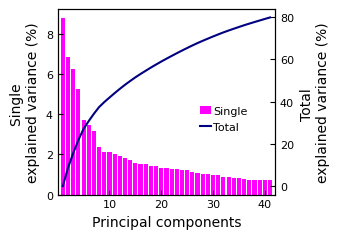

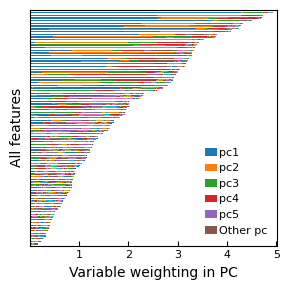

0 padel_catalyst_PubchemFP9
1 padel_solvent _PubchemFP660
2 padel_solvent _PubchemFP1
3 padel_solvent _PubchemFP308
4 padel_Base_PubchemFP440
5 padel_ligand_PubchemFP18
6 padel_XYZ_PubchemFP2
7 padel_AB_PubchemFP341
8 padel_solvent _PubchemFP286
9 AB mmol
10 padel_AB_PubchemFP352
11 padel_AB_PubchemFP708
12 padel_AB_PubchemFP493
13 padel_AB_PubchemFP185
14 padel_AB_PubchemFP440


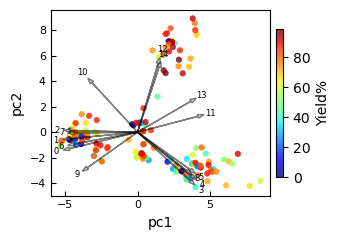

0 padel_catalyst_PubchemFP9
1 padel_solvent _PubchemFP660
2 padel_solvent _PubchemFP1
3 padel_solvent _PubchemFP308
4 padel_Base_PubchemFP440
5 padel_ligand_PubchemFP18
6 padel_XYZ_PubchemFP2
7 padel_AB_PubchemFP341
8 padel_solvent _PubchemFP286
9 AB mmol
10 padel_AB_PubchemFP352
11 padel_AB_PubchemFP708
12 padel_AB_PubchemFP493
13 padel_AB_PubchemFP185
14 padel_AB_PubchemFP440


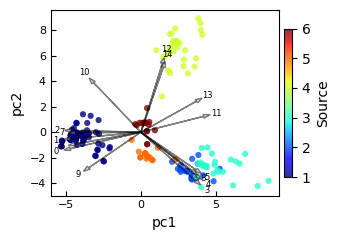

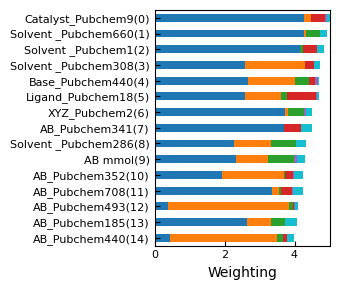

In [6]:
n_pca =0.8
df2_pca, df2_pca_coef, exp_var = perform_pca_n(X, n_pca, if_plot='Figure_PCA_CC_all_features.png', top_features=-1, save_to_file='Figure_PCA_CC_explained_var.png')

colors = Y[Y_label]
topfeature = int(0.1*len(df2_pca_coef))+1

plot_pca_2d(df2_pca, df2_pca_coef, colors, xname='pc1', yname='pc2', 
            size=20, explained_var=exp_var, num_feature=topfeature, data_alpha=0.8, color_map='jet', cbar_label='Yield%',
            #feature_arrow=True, yrange=[-5,10], save_to_file='Figure_PCA_PNL_pubchem_zoom.png')  #data_alpha=1
            feature_arrow=True, save_to_file='Figure_PCA_CC_pubc_yield.png')
colors = Y['source'] #- Y['source'].min()
plot_pca_2d(df2_pca, df2_pca_coef, colors, xname='pc1', yname='pc2', 
            size=20, explained_var=exp_var, num_feature=topfeature, data_alpha=0.8, color_map='jet', cbar_label='Source',
            #feature_arrow=True, yrange=[-5,10], save_to_file='Figure_PCA_PNL_pubchem_zoom.png')  #data_alpha=1
            feature_arrow=True, save_to_file='Figure_PCA_CC_pubc_source.png')
top_fp = feature_weight( df2_pca_coef, exp_var, num_variable=topfeature, if_var_considered=True, #fig_size=(3.5,3),
               header='padel_', save_to_file='Figure_PCA_CC_pubc_TopFeatures.png')


[14:24:06] SMARTS Parse Error: syntax error while parsing: >=2C
[14:24:06] SMARTS Parse Error: Failed parsing SMARTS ' >=2C' for input: ' >=2C'
[14:24:06] SMARTS Parse Error: syntax error while parsing: >=8H
[14:24:06] SMARTS Parse Error: Failed parsing SMARTS ' >=8H' for input: ' >=8H'
[14:24:06] SMARTS Parse Error: syntax error while parsing: O-H
[14:24:06] SMARTS Parse Error: Failed parsing SMARTS 'O-H' for input: 'O-H'
[14:24:06] SMARTS Parse Error: syntax error while parsing: >=1O
[14:24:06] SMARTS Parse Error: Failed parsing SMARTS ' >=1O' for input: ' >=1O'
[14:24:06] SMARTS Parse Error: syntax error while parsing: >=16 H
[14:24:06] SMARTS Parse Error: Failed parsing SMARTS ' >=16 H' for input: ' >=16 H'
[14:24:06] SMARTS Parse Error: syntax error while parsing: >=2any ring size 6
[14:24:06] SMARTS Parse Error: Failed parsing SMARTS ' >=2any ring size 6' for input: ' >=2any ring size 6'


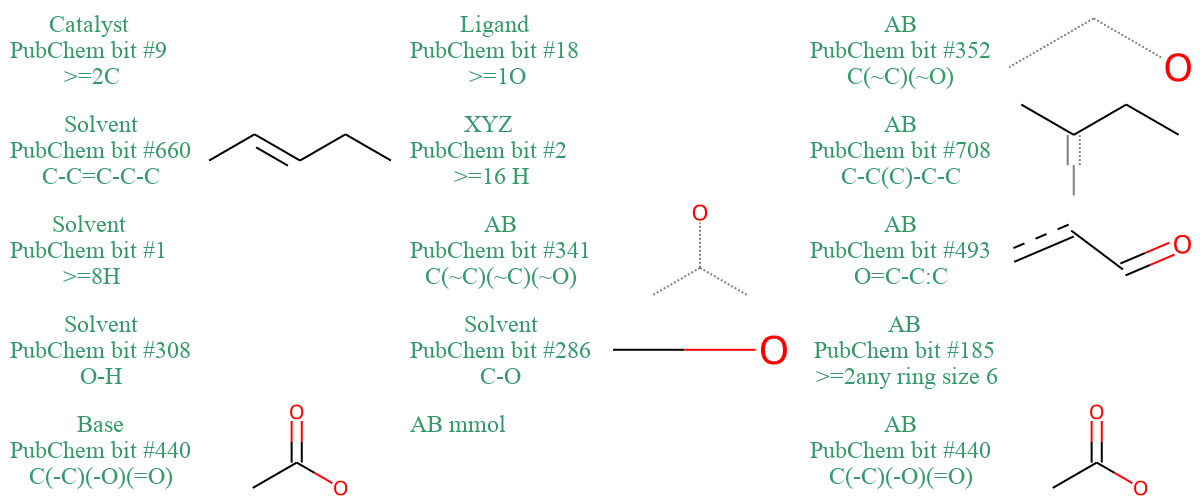

In [7]:
img_pubchem = interpret_pubchemFP_name(top_fp, Translate_pubchem_fingerprint) 
img_pubchem.save(f'Figure_PCA_CC_pubc_VisaulTopFeatures.png')
img_pubchem

# Plot CH

Before clean (149, 6177)
After clean (149, 902)
Num of keep:  126
Num of drop:  776
---------


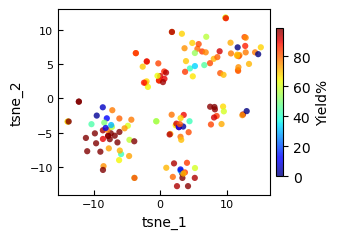

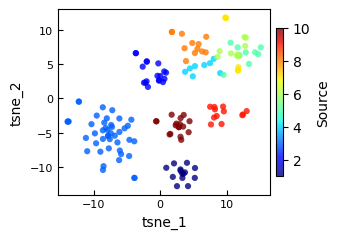

Total Var  0.8037943959380024  from  33
Exp Var:  [0.10644071 0.07565924 0.0622986  0.04807869 0.03914237 0.03325503
 0.02838528 0.02534497 0.02501182 0.02381388 0.02288741 0.02159766
 0.02032309 0.01883701 0.01862513 0.01805753 0.016922   0.0164533
 0.01637082 0.01608292 0.0155374  0.0144739  0.0136564  0.01331257
 0.01176182 0.01145518 0.01106538 0.01076826 0.0102448  0.00981612
 0.00955653 0.00936745 0.00919112]


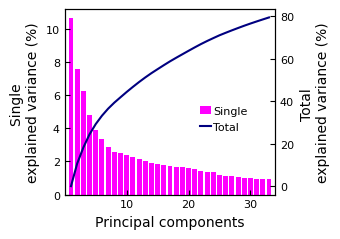

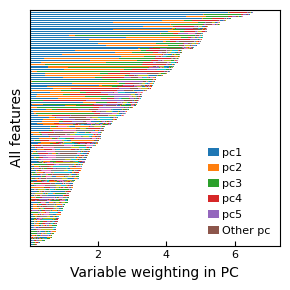

0 X mmol
1 padel_COH-X_PubchemFP493
2 padel_solvent_PubchemFP360
3 padel_AB_PubchemFP420
4 padel_COH-X_PubchemFP490
5 padel_solvent_PubchemFP0
6 padel_AB_PubchemFP490
7 padel_catalyst_PubchemFP19
8 padel_COH-X_PubchemFP579
9 padel_COH-X_PubchemFP341
10 padel_AB_PubchemFP452
11 padel_COH-X_PubchemFP333


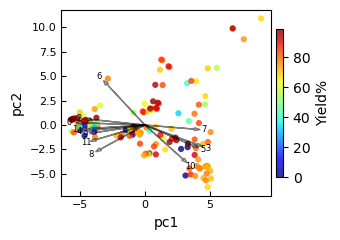

0 X mmol
1 padel_COH-X_PubchemFP493
2 padel_solvent_PubchemFP360
3 padel_AB_PubchemFP420
4 padel_COH-X_PubchemFP490
5 padel_solvent_PubchemFP0
6 padel_AB_PubchemFP490
7 padel_catalyst_PubchemFP19
8 padel_COH-X_PubchemFP579
9 padel_COH-X_PubchemFP341
10 padel_AB_PubchemFP452
11 padel_COH-X_PubchemFP333


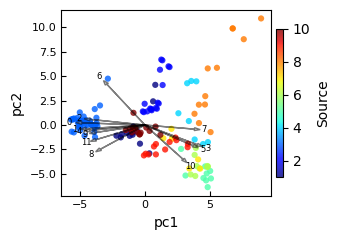

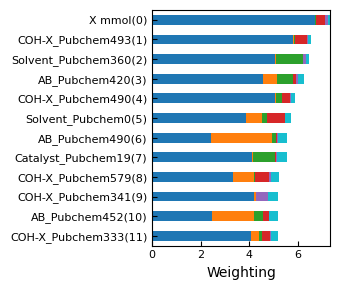

In [8]:
df_ch = pd.read_csv("df_pubchem_CH.csv", index_col=0)
#df_ch.columns = [ c.replace('2_','_') for c in df_ch.columns ]
df_pubchem = clean_std(df_ch)
X_pubchem, _= remove_high_corr_gradually(df_pubchem, cutoff=0.8,)# highlight=['LUMO'])
Y_label = 'Yield%'
Y = X_pubchem[[Y_label,'source']]
X = X_pubchem.drop([Y_label,'source'],axis=1)

## tsne
df2_tsne =  perform_tsne_n( X, n_tsne=2,  
                               verbose=0, 
                               random_state=100,
                               init='pca',
                               learning_rate='auto', 
                               perplexity=20, 
                               n_iter=3000 
                              )
plot_tsne_2d(df2_tsne, Y[Y_label],  xname='tsne_1', yname='tsne_2', cbar_label='Yield%', color_map='jet', save_to_file='Figure_TSNE_CH_pubc_yield.png') 
plot_tsne_2d(df2_tsne, Y['source'], xname='tsne_1', yname='tsne_2', cbar_label='Source', color_map='jet', save_to_file='Figure_TSNE_CH_pubc_source.png') 
# PCA
n_pca =0.8
df2_pca, df2_pca_coef, exp_var = perform_pca_n(X, n_pca, if_plot='Figure_PCA_CH_all_features.png', top_features=-1, save_to_file='Figure_PCA_CH_explained_var.png')

colors = Y[Y_label]
topfeature = int(0.1*len(df2_pca_coef))

plot_pca_2d(df2_pca, df2_pca_coef, colors, xname='pc1', yname='pc2', 
            size=20, explained_var=exp_var, num_feature=topfeature, data_alpha=0.8, color_map='jet', cbar_label='Yield%',
            #feature_arrow=True, yrange=[-5,10], save_to_file='Figure_PCA_PNL_pubchem_zoom.png')  #data_alpha=1
            feature_arrow=True, save_to_file='Figure_PCA_CH_pubc_yield.png')
colors = Y['source'] #- Y['source'].min()
plot_pca_2d(df2_pca, df2_pca_coef, colors, xname='pc1', yname='pc2', 
            size=20, explained_var=exp_var, num_feature=topfeature, data_alpha=0.8, color_map='jet', cbar_label='Source',
            #feature_arrow=True, yrange=[-5,10], save_to_file='Figure_PCA_PNL_pubchem_zoom.png')  #data_alpha=1
            feature_arrow=True, save_to_file='Figure_PCA_CH_pubc_source.png')
top_fp = feature_weight( df2_pca_coef, exp_var, num_variable=topfeature, if_var_considered=True, fig_size=(3.5,3),
               header='padel_', save_to_file='Figure_PCA_CH_pubc_TopFeatures.png')


[14:24:44] SMARTS Parse Error: syntax error while parsing: >=4H
[14:24:44] SMARTS Parse Error: Failed parsing SMARTS ' >=4H' for input: ' >=4H'
[14:24:44] SMARTS Parse Error: syntax error while parsing: >=2O
[14:24:44] SMARTS Parse Error: Failed parsing SMARTS ' >=2O' for input: ' >=2O'


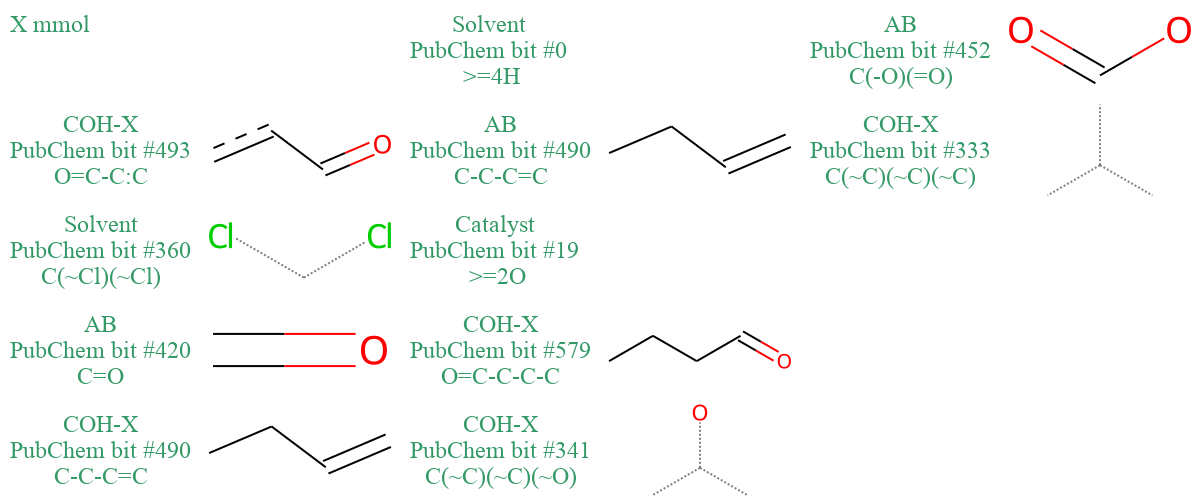

In [9]:
img_pubchem = interpret_pubchemFP_name(top_fp, Translate_pubchem_fingerprint)    
img_pubchem.save(f'Figure_PCA_CH_pubc_VisaulTopFeatures.png')
img_pubchem

# Plot C-N

Before clean (392, 6177)
After clean (392, 1318)
Num of keep:  196
Num of drop:  1122
---------


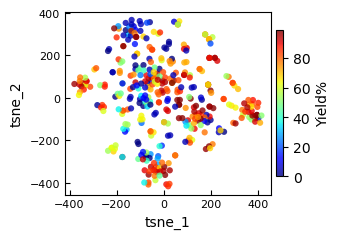

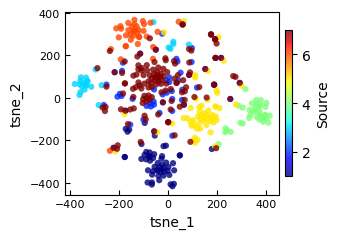

Total Var  0.8045748369690566  from  56
Exp Var:  [0.06862538 0.05576187 0.04021075 0.03344243 0.02936986 0.02708665
 0.0243827  0.02382049 0.02222424 0.02076888 0.0198374  0.01790523
 0.01687291 0.01650725 0.01613274 0.01565041 0.01428583 0.01398118
 0.01341725 0.01260331 0.01218033 0.01185813 0.01136516 0.01123003
 0.01087085 0.01021834 0.01014809 0.00985674 0.00967003 0.00950919
 0.00924257 0.0090849  0.0089626  0.00882424 0.00873333 0.00852861
 0.00838505 0.00824745 0.00815357 0.0078986  0.00779644 0.00775524
 0.007635   0.00758552 0.00754996 0.00716158 0.00704871 0.00677036
 0.00664946 0.00649945 0.00638823 0.00631042 0.00601639 0.00595351
 0.00584663 0.0057534 ]


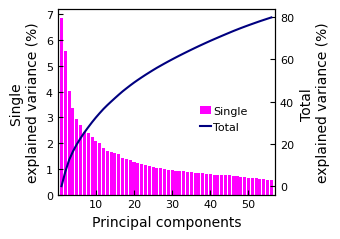

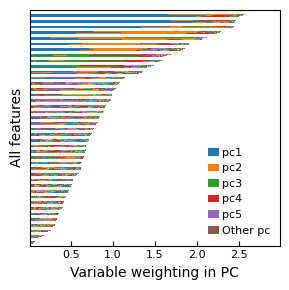

0 padel_catalyst_PubchemFP2
1 padel_WZ_PubchemFP567
2 time hr
3 padel_catalyst_PubchemFP76
4 padel_catalyst_PubchemFP374
5 padel_XY_PubchemFP2
6 padel_catalyst_PubchemFP37
7 padel_catalyst_PubchemFP640
8 padel_XY_PubchemFP540
9 padel_ligand_PubchemFP24
10 padel_XY_PubchemFP180
11 Catalyst mmol
12 padel_XY_PubchemFP650
13 padel_Additive_PubchemFP276
14 padel_Base_PubchemFP30
15 padel_WZ_PubchemFP182
16 padel_Additive_PubchemFP308
17 padel_catalyst_PubchemFP3
18 padel_WZ_PubchemFP712


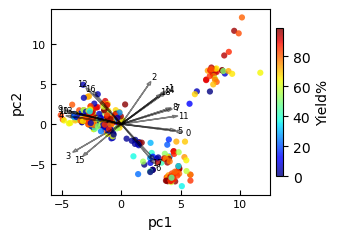

0 padel_catalyst_PubchemFP2
1 padel_WZ_PubchemFP567
2 time hr
3 padel_catalyst_PubchemFP76
4 padel_catalyst_PubchemFP374
5 padel_XY_PubchemFP2
6 padel_catalyst_PubchemFP37
7 padel_catalyst_PubchemFP640
8 padel_XY_PubchemFP540
9 padel_ligand_PubchemFP24
10 padel_XY_PubchemFP180
11 Catalyst mmol
12 padel_XY_PubchemFP650
13 padel_Additive_PubchemFP276
14 padel_Base_PubchemFP30
15 padel_WZ_PubchemFP182
16 padel_Additive_PubchemFP308
17 padel_catalyst_PubchemFP3
18 padel_WZ_PubchemFP712


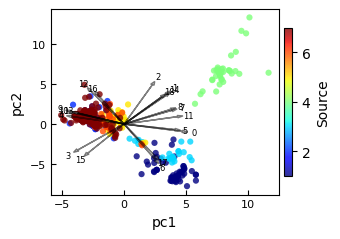

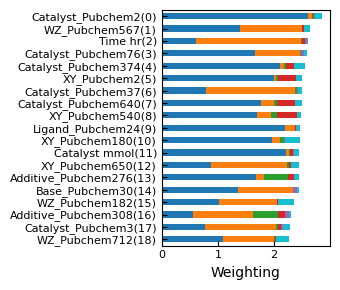

In [10]:
df_cn = pd.read_csv("df_pubchem_CN.csv", index_col=0)
#df_cn.columns = [ c.replace('2_','_') for c in df_cn.columns ]
df_pubchem = clean_std(df_cn)
X_pubchem, _= remove_high_corr_gradually(df_pubchem, cutoff=0.8,)# highlight=['LUMO'])
Y_label = 'Yield%'
Y = X_pubchem[[Y_label,'source']]
X = X_pubchem.drop([Y_label,'source'],axis=1)

## tsne
df2_tsne =  perform_tsne_n( X, n_tsne=2,  
                               verbose=0, 
                               random_state=100,
                               init='pca',
                               learning_rate='auto', 
                               perplexity=20, 
                               n_iter=3000 
                              )
plot_tsne_2d(df2_tsne, Y[Y_label],  xname='tsne_1', yname='tsne_2', 
             cbar_label='Yield%', color_map='jet', save_to_file='Figure_TSNE_CN_pubc_yield.png') 
plot_tsne_2d(df2_tsne, Y['source'], xname='tsne_1', yname='tsne_2', 
             cbar_label='Source', color_map='jet', save_to_file='Figure_TSNE_CN_pubc_source.png') 
# PCA
n_pca =0.8
df2_pca, df2_pca_coef, exp_var = perform_pca_n(X, n_pca, if_plot='Figure_PCA_CN_all_features.png', top_features=-1, save_to_file='Figure_PCA_CN_explained_var.png')

colors = Y[Y_label]
topfeature = int(0.1*len(df2_pca_coef))

plot_pca_2d(df2_pca, df2_pca_coef, colors, xname='pc1', yname='pc2', 
            size=20, explained_var=exp_var, num_feature=topfeature, data_alpha=0.8, color_map='jet', cbar_label='Yield%',
            #feature_arrow=True, yrange=[-5,10], save_to_file='Figure_PCA_PNL_pubchem_zoom.png')  #data_alpha=1
            feature_arrow=True, save_to_file='Figure_PCA_CN_pubc_yield.png')
colors = Y['source'] #- Y['source'].min()
plot_pca_2d(df2_pca, df2_pca_coef, colors, xname='pc1', yname='pc2', 
            size=20, explained_var=exp_var, num_feature=topfeature, data_alpha=0.8, color_map='jet', cbar_label='Source',
            #feature_arrow=True, yrange=[-5,10], save_to_file='Figure_PCA_PNL_pubchem_zoom.png')  #data_alpha=1
            feature_arrow=True, save_to_file='Figure_PCA_CN_pubc_source.png')
top_fp = feature_weight( df2_pca_coef, exp_var, num_variable=topfeature, if_var_considered=True, fig_size=(3.5,3),
               header='padel_', save_to_file='Figure_PCA_CN_pubc_TopFeatures.png')


[14:28:56] SMARTS Parse Error: syntax error while parsing: >=16 H
[14:28:56] SMARTS Parse Error: Failed parsing SMARTS ' >=16 H' for input: ' >=16 H'
[14:28:56] SMARTS Parse Error: syntax error while parsing: >=1Pd
[14:28:56] SMARTS Parse Error: Failed parsing SMARTS ' >=1Pd' for input: ' >=1Pd'
[14:28:56] SMARTS Parse Error: syntax error while parsing: C(~H)(~H)(~H)
[14:28:56] SMARTS Parse Error: Failed parsing SMARTS 'C(~H)(~H)(~H)' for input: 'C(~H)(~H)(~H)'
[14:28:56] SMARTS Parse Error: syntax error while parsing: >=16 H
[14:28:56] SMARTS Parse Error: Failed parsing SMARTS ' >=16 H' for input: ' >=16 H'
[14:28:56] SMARTS Parse Error: syntax error while parsing: >=1Cl
[14:28:56] SMARTS Parse Error: Failed parsing SMARTS ' >=1Cl' for input: ' >=1Cl'
[14:28:56] SMARTS Parse Error: syntax error while parsing: >=2F
[14:28:56] SMARTS Parse Error: Failed parsing SMARTS ' >=2F' for input: ' >=2F'
[14:28:56] SMARTS Parse Error: syntax error while parsing: >=1saturated or aro
[14:28:56] SMA

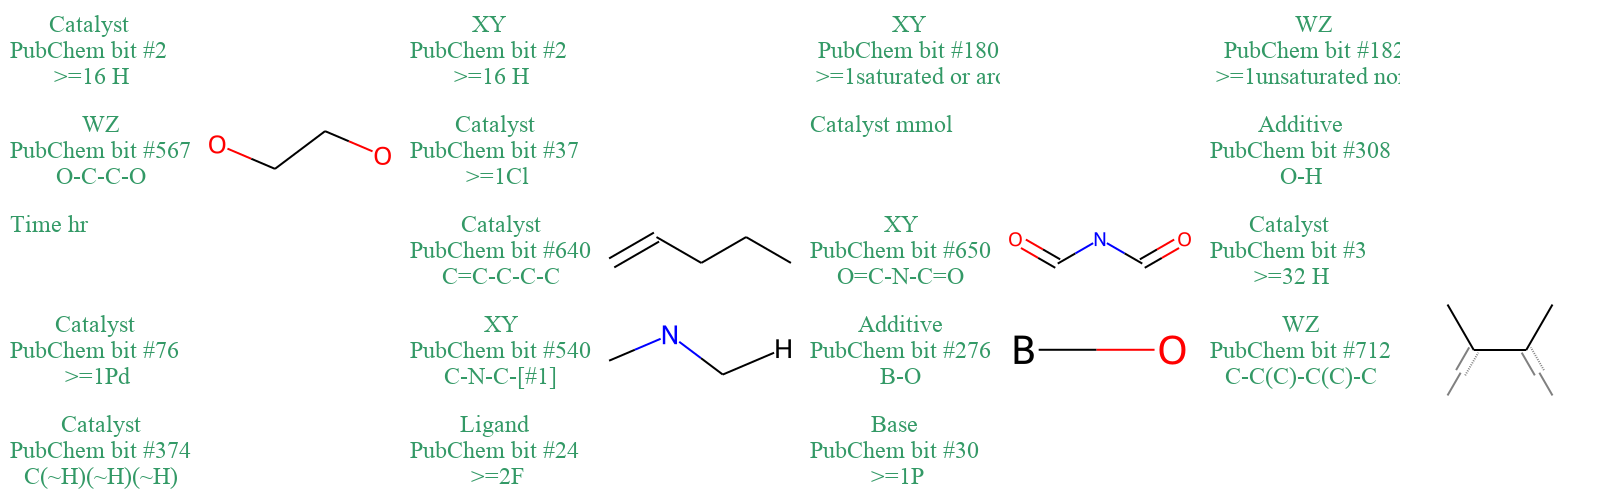

In [11]:
img_pubchem = interpret_pubchemFP_name(top_fp, Translate_pubchem_fingerprint)    
img_pubchem.save(f'Figure_PCA_CN_pubc_VisaulTopFeatures.png')
img_pubchem  

# Plot C-O

Before clean (127, 3531)
After clean (127, 502)
Num of keep:  60
Num of drop:  442
---------


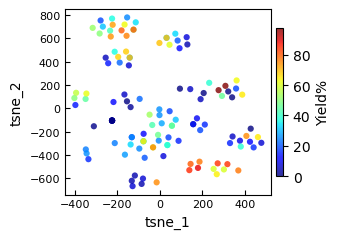

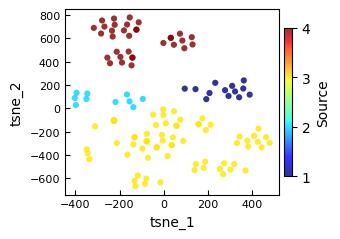

Total Var  0.8189871753864533  from  18
Exp Var:  [0.16169711 0.10687248 0.07700422 0.06656962 0.04586395 0.04476804
 0.04258565 0.03231044 0.02904127 0.02823248 0.02782835 0.0267936
 0.02497038 0.02427653 0.02138426 0.02046325 0.01931402 0.01901153]


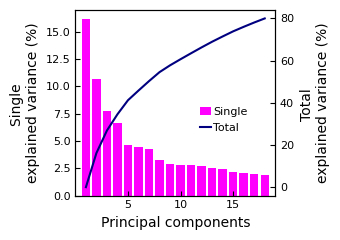

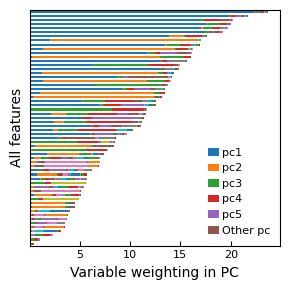

0 padel_catalyst_PubchemFP10
1 padel_catalyst_PubchemFP351
2 padel_catalyst_PubchemFP20
3 padel_catalyst_PubchemFP12
4 padel_solvent _PubchemFP0
5 padel_catalyst_PubchemFP192
6 Temp C
7 padel_solvent _PubchemFP179
8 padel_catalyst_PubchemFP516
9 padel_solvent _PubchemFP11


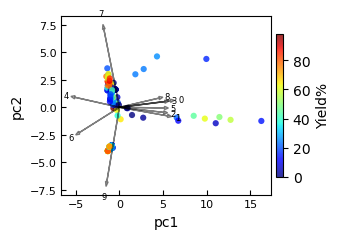

0 padel_catalyst_PubchemFP10
1 padel_catalyst_PubchemFP351
2 padel_catalyst_PubchemFP20
3 padel_catalyst_PubchemFP12
4 padel_solvent _PubchemFP0
5 padel_catalyst_PubchemFP192
6 Temp C
7 padel_solvent _PubchemFP179
8 padel_catalyst_PubchemFP516
9 padel_solvent _PubchemFP11


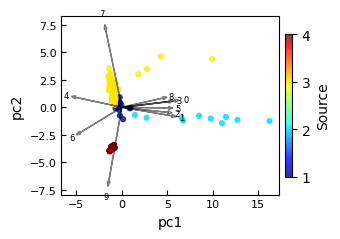

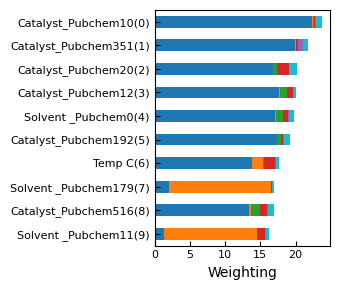

In [12]:
df_co = pd.read_csv("df_pubchem_CO.csv", index_col=0)
df_pubchem = clean_std(df_co)
X_pubchem, _= remove_high_corr_gradually(df_pubchem, cutoff=0.8,)# highlight=['LUMO'])
Y_label = 'Y Yield%'
Y = X_pubchem[[Y_label,'source']]
X = X_pubchem.drop([Y_label,'source'],axis=1)

## tsne
df2_tsne =  perform_tsne_n( X, n_tsne=2,  
                               verbose=0, 
                               random_state=100,
                               init='pca',
                               learning_rate='auto', 
                               perplexity=20, 
                               n_iter=3000 
                              )
plot_tsne_2d(df2_tsne, Y[Y_label],  xname='tsne_1', yname='tsne_2', 
             cbar_label='Yield%', color_map='jet', save_to_file='Figure_TSNE_CO_pubc_yield.png') 
plot_tsne_2d(df2_tsne, Y['source'], xname='tsne_1', yname='tsne_2', 
             cbar_label='Source', color_map='jet', save_to_file='Figure_TSNE_CO_pubc_source.png') 
# PCA
n_pca =0.8
df2_pca, df2_pca_coef, exp_var = perform_pca_n(X, n_pca, if_plot='Figure_PCA_CO_all_features.png', top_features=-1, save_to_file='Figure_PCA_CO_explained_var.png')
colors = Y[Y_label]
topfeature = 10 #int(0.1*len(df2_pca_coef))

plot_pca_2d(df2_pca, df2_pca_coef, colors, xname='pc1', yname='pc2', 
            size=20, explained_var=exp_var, num_feature=topfeature, data_alpha=0.8, color_map='jet', cbar_label='Yield%',
            #feature_arrow=True, yrange=[-5,10], save_to_file='Figure_PCA_PNL_pubchem_zoom.png')  #data_alpha=1
            feature_arrow=True, save_to_file='Figure_PCA_CO_pubc_yield.png')
colors = Y['source'] #- Y['source'].min()
plot_pca_2d(df2_pca, df2_pca_coef, colors, xname='pc1', yname='pc2', 
            size=20, explained_var=exp_var, num_feature=topfeature, data_alpha=0.8, color_map='jet', cbar_label='Source',
            #feature_arrow=True, yrange=[-5,10], save_to_file='Figure_PCA_PNL_pubchem_zoom.png')  #data_alpha=1
            feature_arrow=True, save_to_file='Figure_PCA_CO_pubc_source.png')
top_fp = feature_weight( df2_pca_coef, exp_var, num_variable=topfeature, if_var_considered=True, fig_size=(3.5,3),
               header='padel_', save_to_file='Figure_PCA_CO_pubc_TopFeatures.png')


[14:29:43] SMARTS Parse Error: syntax error while parsing: >=4C
[14:29:43] SMARTS Parse Error: Failed parsing SMARTS ' >=4C' for input: ' >=4C'
[14:29:43] SMARTS Parse Error: syntax error while parsing: >=4O
[14:29:43] SMARTS Parse Error: Failed parsing SMARTS ' >=4O' for input: ' >=4O'
[14:29:43] SMARTS Parse Error: syntax error while parsing: >=16 C
[14:29:43] SMARTS Parse Error: Failed parsing SMARTS ' >=16 C' for input: ' >=16 C'
[14:29:43] SMARTS Parse Error: syntax error while parsing: >=4H
[14:29:43] SMARTS Parse Error: Failed parsing SMARTS ' >=4H' for input: ' >=4H'
[14:29:43] SMARTS Parse Error: syntax error while parsing: >=3any ring size 6
[14:29:43] SMARTS Parse Error: Failed parsing SMARTS ' >=3any ring size 6' for input: ' >=3any ring size 6'
[14:29:43] SMARTS Parse Error: syntax error while parsing: >=1saturated or aro
[14:29:43] SMARTS Parse Error: Failed parsing SMARTS ' >=1saturated or aro' for input: ' >=1saturated or aro'
[14:29:43] SMARTS Parse Error: syntax error

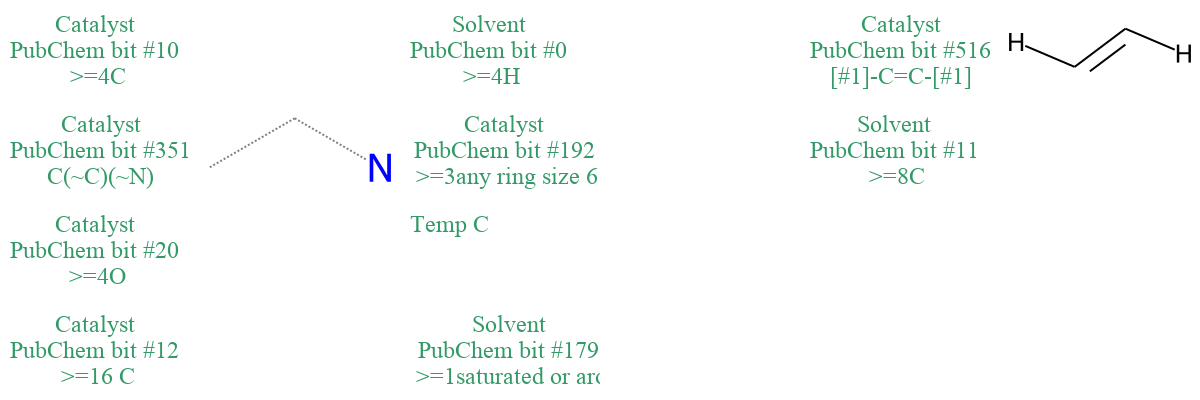

In [13]:
img_pubchem = interpret_pubchemFP_name(top_fp, Translate_pubchem_fingerprint, num_rows=4)    
img_pubchem.save(f'Figure_PCA_CO_pubc_VisaulTopFeatures.png')
img_pubchem  

# All analysis

3.5543766578249327 -0.5119363395225776


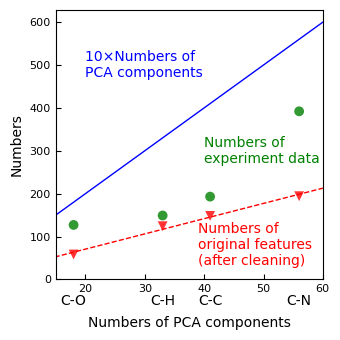

In [14]:
n_pca = [41,33,56,18]
n_features = [148,124,194,58]
n_exp = [193,149,392,127]
label = ['C-C','C-H','C-N','C-O']

fig, axs = plt.subplots(1,1, figsize=(3.5,3.5),tight_layout=True)

size = 50
im = axs.scatter( n_pca, n_features, c='r',marker='v',alpha=0.8,edgecolors='none',s=size)
im = axs.scatter( n_pca, n_exp, c='g',marker='o',alpha=0.8,edgecolors='none',s=size)
#im = axs.scatter( n_pca, n_pca, c='k',marker='o',alpha=0.8,edgecolors='none',s=size)
a,b = np.polyfit(n_pca, n_features, 1)
print(a,b)
x = [10,60]
y = [a*xx+b for xx in x]
axs.plot(x,y, '--', color='r', lw=1)
y = [ xx*10 for xx in x]
axs.plot(x,y, '-', color='b', lw=1)

axs.set_xlim((15,60))
axs.set_ylim(bottom=0)
axs.set_xlabel('\nNumbers of PCA components',fontsize=10) ## input X name
axs.set_ylabel('Numbers',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize=8)

axs.text( 39,80,"Numbers of \noriginal features \n(after cleaning)", color='r',ha='left', va='center', fontsize=10 )
axs.text( 40,300,"Numbers of \nexperiment data", color='g',ha='left', va='center', fontsize=10 )
axs.text( 20,500,"10×Numbers of \nPCA components", color='b',ha='left', va='center', fontsize=10 )

for x,l in zip(n_pca,label):
    axs.text( x,-50,l, color='k',ha='center', va='center', fontsize=10 )
plt.savefig('Summary_correlation.png', dpi=1200)   
plt.show()